In [92]:
import os.path

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from farich_functions import *

plt.rcParams['font.size'] = 12

In [19]:
warnings.filterwarnings("ignore")

In [20]:
filepath = os.path.join("data", "decay_test_ka2.root")

In [21]:
file = uproot.open(filepath)

In [22]:
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())

In [23]:
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array()) # 40% К куда-то пропадают в фариче

In [94]:
def primary_particle_match_test(primary_particles_array, ids_to_check, ids_to_match, verbose=False):
    for i in range(len(ids_to_check)):
        if primary_particles_array[ids_to_check[i]] != ids_to_match[i]:
            if verbose:
                print(f'Expected {ids_to_match[i]} but got {primary_particles_array[ids_to_check[i]]} in {ids_to_check[i]}-th position')
            return False    
    return True

In [99]:
def find_primary_in_farich(primary_particles_array, farich_particles_array, primary_id, pdg_id, verbose=False):
    find_index_of_pdg_id = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == pdg_id)).size and (idx[-1] < arr.size) else False)
    if primary_particles_array[primary_id] == pdg_id:
        if find_index_of_pdg_id(farich_particles_array) is not False:
            if primary_particles_array[primary_id] != farich_particles_array[find_index_ka(farich_pdgid[i])]:
                if verbose:
                    print('Mismatch', i)
                mismatches.append(i)
                is_good = False
        else:
            if verbose:
                print('No ka in event', i)
            is_good = False
            no_ka.append(i)
    if is_good:
        good_events.append(i)
        primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
        primary_particle_in_primary_idx.append(2)

In [100]:
i = 0
empty_farich = 0
important_particle_ind = 3
mismatches = []
good_events = []
good_mu_events = []
good_ka_events = []
primary_particle_idx = []
primary_particle_in_primary_idx = []
no_mu_in_mu = []
no_ka = []
# find_index = lambda arr: (idx[-1]+1 if (idx := np.flatnonzero(arr == -22)).size and (idx[-1]+1 < arr.size) else 0) # моржовый оператор :)
find_index = lambda arr: (idx[-1] + 1 if (idx := np.flatnonzero(np.isin(arr, [-22, -11]))).size and (idx[-1] + 1 < arr.size) else 0)
find_index_mu = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -13)).size and (idx[-1] < arr.size) else False)
find_index_ka = lambda arr: (idx[-1] if (idx := np.flatnonzero(arr == -321)).size and (idx[-1] < arr.size) else False)

# need 2 rings per event now...

for primary_particles in primary_pdgid:
    is_good = True
                
    if farich_pdgid[i].shape[0] == 0 or np.flatnonzero(farich_pdgid[i] + 22).shape[0] == 0:
        empty_farich += 1
        is_good = False
        
    if is_good:
        is_good = primary_particle_match_test(primary_particles, [0, 1, 2], [30443, 421, -321], True)

    if primary_particles[2] == -321 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_ka(farich_pdgid[i]) is not False:
                if primary_particles[2] != farich_pdgid[i][find_index_ka(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No ka in event', i)
                is_good = False
                no_ka.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_ka(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(2)
            
            
    if primary_particles[important_particle_ind] == -13 and is_good:
        if farich_pdgid[i].shape[0] != 0 and np.flatnonzero(farich_pdgid[i] + 22).shape[0] != 0:
            if find_index_mu(farich_pdgid[i]) is not False:
                if primary_particles[important_particle_ind] != farich_pdgid[i][find_index_mu(farich_pdgid[i])]:
                    print('Mismatch', i)
                    mismatches.append(i)
                    is_good = False
            else:
                # print('No mu in mu event', i)
                is_good = False
                no_mu_in_mu.append(i)
        if is_good:
            good_events.append(i)
            primary_particle_idx.append(find_index_mu(farich_pdgid[i]))
            primary_particle_in_primary_idx.append(important_particle_ind)
        if not is_good:
            if len(good_events) != 0:
                good_events.pop()
                primary_particle_idx.pop()
                primary_particle_in_primary_idx.pop()
    

    # if is_good:
    #     good_events.append(i)
    #     primary_particle_idx.append(find_index(farich_pdgid[i]))
    i += 1
    

print('Empty Farich:',empty_farich)
print('Mismatches: ',len(mismatches))
print('Missing K: ',len(no_ka))
print('Missing Mu in Mu event: ',len(no_mu_in_mu))
print('Full bad events: ', len(mismatches) + empty_farich + len(set(np.concatenate([no_mu_in_mu, no_ka]))))
print('Good Events:', i - len(mismatches) - empty_farich - len(set(np.concatenate([no_mu_in_mu, no_ka]))))
print(len(good_events))
print(len(set(good_events)))
print(- len(set(good_events)) + len(good_events))

Empty Farich: 753
Mismatches:  0
Missing K:  3235
Missing Mu in Mu event:  542
Full bad events:  4530
Good Events: 5470
7931
5470
2461


In [25]:
farich_energy = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.energy'].array())[good_events]
farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]

primary_momentum_x = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
primary_momentum_y = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
primary_momentum_z = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]

farich_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
farich_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
farich_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
farich_t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]

In [26]:
np.sum([primary_pdgid[i][2] == -321 for i in range(10000)]) 

10000

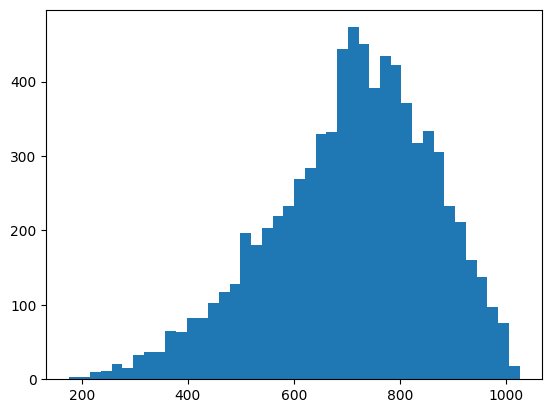

In [27]:
plt.hist([np.sqrt((primary_momentum_x[i][2]) ** 2 + (primary_momentum_y[i][2]) ** 2 + (primary_momentum_z[i][2]) ** 2) * 1000 for i in range(len(good_events))], bins='auto')
plt.show()

In [28]:
def init_coords_decay(file, grid):
    x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.x"].array())[good_events]
    y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.y"].array())[good_events]
    z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.postStepPosition.z"].array())[good_events]
    wvs = (1239.841 / np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.energy"].array()) * 1e-9)[good_events]
    t = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']["FarichBarrelG4Hits.localTime"].array())[good_events]
    
    farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())[good_events]
    farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())[good_events]
    farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())[good_events]
    farich_pdgid =      np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())[good_events]
        
    x3 = np.array([farich_momentum_x[i][primary_particle_idx[i]] for i in range(farich_momentum_x.shape[0])])
    y3 = np.array([farich_momentum_y[i][primary_particle_idx[i]] for i in range(farich_momentum_y.shape[0])])
    z3 = np.array([farich_momentum_z[i][primary_particle_idx[i]] for i in range(farich_momentum_z.shape[0])])
    id = np.array([farich_pdgid[i][primary_particle_idx[i]] for i in range(farich_pdgid.shape[0])])
  
    xi = np.array([x[i][primary_particle_idx[i]] for i in range(x.shape[0])])
    yi = np.array([y[i][primary_particle_idx[i]] for i in range(y.shape[0])])
    zi = np.array([z[i][primary_particle_idx[i]] for i in range(z.shape[0])])
    
    x3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())[good_events]
    y3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())[good_events]
    z3 = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())[good_events]
    x3 = np.array([x3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    y3 = np.array([y3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    z3 = np.array([z3[i][primary_particle_in_primary_idx[i]] for i in range(len(good_events))])
    # Объединяем массивы, сохраняя структуру массивов
    true_direction_coordinates = np.stack((x3, y3, z3), axis=1)
    intersections = np.stack((xi, yi, zi), axis=1)
    for i in range(len(wvs)):
        wvs[i] = lin_move_to_grid(wvs[i], grid[2])
    coordinates = np.column_stack((x, y, z, wvs, t))
    return coordinates, true_direction_coordinates, intersections, id


In [29]:
datadir = "data"
sipm_eff, PDE_wvs = init_sipm_eff()
for key in sipm_eff.keys():
    sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

x_grid = np.arange(
    -3 * norm_r * np.sin(np.pi / 27),
    3 * norm_r * np.sin(np.pi / 27),
    SIPM_CELL_SIZE,
)
z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
grid = (x_grid, z_grid, PDE_wvs)

decay_file = uproot.open(filepath)
coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
    decay_file, grid
)


In [30]:
intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

array([[ 0.49400845,  0.46695158, -0.32004154],
       [-0.37547314, -0.48471576, -0.5920265 ],
       [ 0.28605416,  0.16623537,  0.1641188 ],
       ...,
       [ 0.16258612, -0.55150247,  0.07975789],
       [ 0.00072456,  0.41843048, -0.36699966],
       [-0.32155937,  0.2185532 ,  0.48274177]], dtype=float32)

In [31]:
def find_cylinder_intersections(vectors, R=1000):
    # vectors - массив размерности (N, 3)
    # R - радиус цилиндра
    
    # Вычисляем t для каждого вектора
    a_x = vectors[:, 0]
    a_y = vectors[:, 1]
    denominator = np.sqrt(a_x**2 + a_y**2)
    
    # Избегаем деления на ноль (векторы, параллельные оси z)
    mask = denominator != 0
    t = np.zeros_like(denominator)
    t[mask] = R / denominator[mask]
    
    # Вычисляем координаты пересечения
    intersections = vectors * t[:, np.newaxis]
    
    return intersections


In [32]:
intersection_diffs = np.sqrt(np.sum((find_cylinder_intersections(intersections, R=1000) - intersections) ** 2, axis=1))

In [33]:
intersection_diffs[intersection_diffs > 100].shape 

(0,)

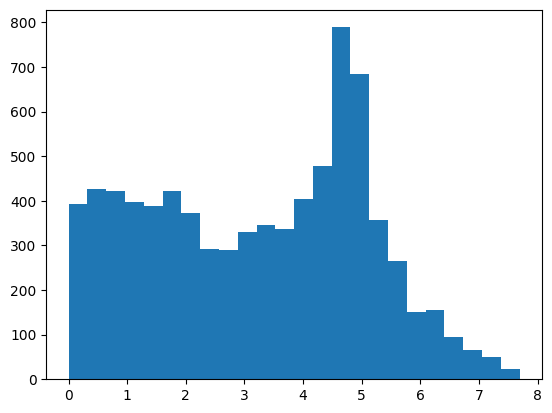

In [34]:
plt.hist(intersection_diffs[intersection_diffs < 100], bins='auto') # Короче, просто используем intersections, координаты важнее
plt.show() 

In [37]:
def find_intersections_for_decay(full_coords):
    intersections = np.zeros((full_coords.shape[0], 3))
    zeros = np.zeros((1, 3))
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i] / 1000
        pca = PCA(n_components=1)

        # if event_coords[0].shape[0] == 1:
        # print(event_coords)
        event_coords = [[0, arr] for arr in event_coords]
        # print(event_coords)
        pca.fit(np.column_stack(event_coords))
        line_direction = pca.components_[0]
        line_point = pca.mean_

        # Calculate the parameter t for the intersection with the plane y=1000
        p_y = line_point[1]
        d_y = line_direction[1]
        t = (1000 - p_y) / d_y

        # Find the intersection point
        intersection_point = line_point + t * line_direction

        # print(f"Line direction: {line_direction}")
        # print(f"Point on the line: {line_point}")
        # print(f"Intersection point with the plane y=1000: {intersection_point}")
        for j in range(3):
            intersections[i][j] = intersection_point[j]
    return intersections


In [38]:
def rotate_lines_for_decay(full_coords):
    angles = np.zeros(full_coords.shape[0])
    for i in range(full_coords.shape[0]):
        event_coords = full_coords[i]
        rotated_event_coords, angles[i] = rotate_line_for_decay(event_coords)

        for j in range(3):
            full_coords[i][j] = rotated_event_coords[:, j]
    return angles


def rotate_line_for_decay(coords):
    angles = np.arctan2(coords[1], coords[0]) % (2 * np.pi)
    # print(angles)
    try:
        median_angle = angles
    except IndexError:
        print(angles)
        median_angle = np.median(angles)
    median_angle = lin_move_to_grid(np.array([median_angle]), plane_angles)
    # print(angles)
    angle_to_rotate = np.pi / 2 - median_angle
    # print(angle_to_rotate)
    x, y = rotate_point_on_line(coords, angle_to_rotate)
    return np.column_stack((x, y, coords[2])), median_angle


In [39]:
def create_edf_decay(
    filepath="fullsim_optical_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root",
    uncertain_angle=False,
):
    datadir = "data"
    sipm_eff, PDE_wvs = init_sipm_eff()
    for key in sipm_eff.keys():
        sipm_eff[key] = sipm_eff[key] / 0.55414 * 0.38

    x_grid = np.arange(
        -3 * norm_r * np.sin(np.pi / 27),
        3 * norm_r * np.sin(np.pi / 27),
        SIPM_CELL_SIZE,
    )
    z_grid = np.arange(-1400, 1400, SIPM_CELL_SIZE)
    grid = (x_grid, z_grid, PDE_wvs)

    decay_file = uproot.open(os.path.join(datadir, filepath))
    coordinates, true_direction_coordinates, intersections, ids = init_coords_decay(
        decay_file, grid
    )
    
    
    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)

    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    true_direction_coordinates = intersections / np.linalg.norm(intersections, axis=1)[:, None] * np.linalg.norm(true_direction_coordinates, axis=1)[:, None]

    if uncertain_angle:
        uncertainty_introduction_to_direction(true_direction_coordinates)
    
    sipm_sim(coordinates, sipm_eff)

    idx_to_drop = []
    for i in range(coordinates.shape[0]):
        if coordinates[i][0].shape[0] == 0:
            idx_to_drop.append(i)
    coordinates = np.delete(coordinates, idx_to_drop, axis=0)
    true_direction_coordinates = np.delete(
        true_direction_coordinates, idx_to_drop, axis=0
    )
    intersections = np.delete(intersections, idx_to_drop, axis=0)
    ids = np.delete(ids, idx_to_drop)
    print(coordinates.shape)
    print(true_direction_coordinates.shape)

    main_angles = rotate_lines_for_decay(intersections) # Rotates intersection points
    
    intersections = find_intersections_for_decay(intersections)  # May need to rewrite both to treat elements as scalasrs and to change reference point from 0
    
    rotate_events(coordinates, main_angles)   # There are events with extra rings somewhere around angle idx 13-16
    move_events_to_grid(coordinates, grid)
    repeat_nums = np.array([coord[0].shape[0] for coord in coordinates])
    edf = pd.DataFrame(coordinates, columns=["x_c", "y_c", "z_c", "wv_c", "t_c"])

    unraveled_data = {col: [] for col in edf.columns}
    row_indices = []

    # Iterate over the DataFrame and unravel the arrays
    for i, row in edf.iterrows():
        max_length = max(len(row[col]) for col in edf.columns)
        for k in range(max_length):
            row_indices.append((i, k))
            for col in edf.columns:
                if k < len(row[col]):
                    unraveled_data[col].append(row[col][k])
                else:
                    unraveled_data[col].append(
                        np.nan
                    )  # Handle cases where arrays are of different lengths

    # Create a new DataFrame from the unraveled data
    unraveled_df = pd.DataFrame(unraveled_data)

    # Create a MultiIndex for the rows
    multi_index = pd.MultiIndex.from_tuples(row_indices, names=["entry", "subentry"])
    unraveled_df.index = multi_index

    edf = unraveled_df

    edf["x_i"] = np.repeat(intersections[:, 0], repeat_nums, axis=0)
    edf["z_i"] = np.repeat(intersections[:, 2], repeat_nums, axis=0)

    x = y = z = x3 = y3 = z3 = unraveled_data = row_indices   = wvs = coordinates = file = coordinates_low = file_low = 0 # = main_angles

    bdf = pd.DataFrame()
    gdf = pd.DataFrame()
    gdf["nhits"] = repeat_nums

    mu_mass = 105.65
    pi_mass = 139.57
    ka_mass = 493.68
    # mass = mu_mass if is_mu else (ka_mass if is_ka else pi_mass)
    mass = np.array([mu_mass if ids[i] == -13 else ka_mass for i in range(ids.shape[0])])
    # edf.drop("y_c", axis=1, inplace=True)
    edf.rename(columns={"y_c": "tmp_c"}, inplace=True)
    edf.drop("wv_c", axis=1, inplace=True)
    edf.rename(columns={"z_c": "y_c", "z_i": "y_i"}, inplace=True)
    edf.rename(columns={"tmp_c": "z_c"}, inplace=True)
    # edf["z_c"] = np.zeros(edf.shape[0]) + 1000  
    # edf["mass"] = np.ones(edf.shape[0]) * mass
    edf["mass"] = np.repeat(
        mass,
        repeat_nums,
        axis=0,
    )
    edf["true_p"] = np.repeat(
        np.linalg.norm(true_direction_coordinates.astype("float"), axis=1) * 1000,
        repeat_nums,
        axis=0,
    )
    edf["beta"] = edf.true_p / np.sqrt(edf.mass**2 + edf.true_p**2)
    edf["x_p"] = np.zeros(edf.shape[0])
    edf["y_p"] = np.zeros(edf.shape[0])
    edf["z_p"] = np.zeros(edf.shape[0])
    edf["nx_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 0],
        repeat_nums,
        axis=0,
    )
    edf["ny_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 2],
        repeat_nums,
        axis=0,
    )
    edf["nz_p"] = np.repeat(
        (
            intersections
            / np.array(
                [
                    np.linalg.norm(intersections.astype("float"), axis=1)
                    for i in range(3)
                ]
            ).T
        ).astype("float")[:, 1],
        repeat_nums,
        axis=0,
    )

    true_direction_coordinates = repeat_nums = true_direction_coordinates_low = mass = intersections = 0
    return edf, bdf, gdf, main_angles


In [53]:
def enforce_float32(df):
    return df.astype({col: np.float32 for col in df.select_dtypes(include=['float64']).columns})

In [104]:
idf = pd.DataFrame()
idf['W'] = [35.]
# idf['W'] = [40.]

idf['zdis'] = [800.]
idf['distance'] = [205.]  # 200
idf['n_mean'] = [1.04511]
# 
# idf['n_mean'] = [1.0502]

idf['pixel_size'] = [3.16]
mu_mass = 105.65
pi_mass = 139.57
ka_mass = 493.68

In [105]:
mu_pi_ka = True
if mu_pi_ka:
    edf_mu, bdf_mu, gdf_mu = create_edf('fullsim_3particles_2000_mu_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=11,
                               uncertain_angle=False, is_mu=True, is_ka=False)
    edf_pi, bdf_pi, gdf_pi = create_edf('fullsim_3particles_2000_pi_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                               uncertain_angle=False, is_mu=False, is_ka=False)
    edf_ka, bdf_ka, gdf_ka = create_edf('fullsim_3particles_2000_ka_bin_1_FARICH_35mm_no_no_trackers.root', sample_num=None, num_of_files=10,
                                    uncertain_angle=False, is_mu=False, is_ka=True)
    
    shift_ind = np.array(edf_mu.index.get_level_values(0))[-1] + 1
    new_index = edf_pi.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_pi.index = pd.MultiIndex.from_tuples(new_index, names=edf_mu.index.names)
    gdf_pi.index = np.array(gdf_pi.index) + np.array(gdf_mu.index)[-1] + 1

    shift_ind = np.array(edf_pi.index.get_level_values(0))[-1] + 1
    new_index = edf_ka.index.map(lambda idx: (idx[0] + shift_ind, idx[1]))
    edf_ka.index = pd.MultiIndex.from_tuples(new_index, names=edf_pi.index.names)
    gdf_ka.index = np.array(gdf_ka.index) + np.array(gdf_pi.index)[-1] + 1


    edf_conc = pd.concat([edf_mu, edf_pi, edf_ka])
    gdf_conc = pd.concat([gdf_mu, gdf_pi, gdf_ka])
    
    edf_mu = gdf_mu = edf_ka = gdf_ka = edf_pi = gdf_pi = 0
    edf_conc = enforce_float32(edf_conc)

(22000, 5)
(22000, 3)
(21104, 5)
(21104, 3)
(19993, 5)
(19993, 3)
(19878, 5)
(19878, 3)
(19986, 5)
(19986, 3)
(19857, 5)
(19857, 3)


In [106]:
avg_sigmas = (4, 5)
avg_t_sigmas = (4, 5)
num_of_groups = 10
what_to_group = 'beta'
r_width = float(idf.pixel_size.iloc[0]) * 2
t_width = 0.25
t_step = 0.25
r_factor = 2 # not to change
t_factor = int(t_width / t_step)
weighed = True
deg_lim = False
param_fit = False
useuse_decision_tree = True


calibration_func = pol # pol
param_calibration_func = pol2_pol2 # d3pol2
p0 = (0.9, -5, 340) # (.95, 0, 300) #(.01, 1e-3, 1e-4)
p0_c =  (1.219, -0.5588, 0.2946, 864.4, -1922, 1055, -2535, 6572, -3751)
num_of_calibration_params = 3 # 3
num_of_param_fit_params = 3 # for param fit both prev and this number are important, cal_func as well, therefore p0 and p0_C
target_variable = 'beta'
target_angle = 'theta_p'
num_of_theta_intervals = 11 # 11


# sample_size = 12
cal_arr = False
errs = False

beta_sigms = []
beta_sigms_yerr = []
beta_sigms_deglim = []
beta_sigms_yerr_deglim = []


r_bins = np.arange(16, 80, step=3.3)
r_bins = np.array([[r_bins[i], r_bins[i + 2]] for i in range(len(r_bins) - 2)])
t_bins = np.arange(0, 7, step=0.25)
t_bins = np.array([[t_bins[i], t_bins[i + 1]] for i in range(len(t_bins) - 1)])

background_means_dict = {'1e6': 0.012, '1e5': 0.0015}
background_stds_dict = {'1e6': 0.0175, '1e5': 0.0055}

background_mean = background_means_dict['1e6']
background_std = background_stds_dict['1e6']

batch_size = 10000
num_of_classes = 4

In [107]:
dcr = '0'
print(dcr)
timer_start = perf_counter()
edf_d = edf_conc.copy()
gdf_d = gdf_conc.copy()
bdf_d = pd.DataFrame()
edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
edf_d = applySpaceCut(edf_d)
planeRecalculation(edf_d, idf)
planeRotation(edf_d)
edf_d = applySecondSpaceCut(edf_d)
edf_to_bdf(edf_d.mass, bdf_d)
edf_to_bdf(edf_d.true_p, bdf_d)
bdf_d.rename(columns={'true_p': 'momentum'}, inplace=True)
edf_to_bdf(edf_d.beta, bdf_d)
recoAngles(edf_d, idf)
primaryDirectionRecalculation(edf_d)

recoAngles(edf_d, idf, rotation_mode=True)

calculateSignalCounts(edf_d, bdf_d)

cal_arr, errs = rSlidingWindow(edf_d, idf, bdf_d, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                           step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                           calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                           target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
    
print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))

0
    Generate noise with DCR per mm^2 0.0, mean number of hits per event: 0.00.
Time elapsed on current DCR:  63


In [117]:
pd.read_pickle(os.path.join('data', 'pickled_bdf_1e5.pkl'))

,mass,momentum,beta,signal_counts,param_group,theta_p,cos_theta_p,unfixed_calculated_r_2d_4_rsigms_4_tsigms,beta_from_calc_r_4_rsigms_4_tsigms,delta_beta_4_rsigms_4_tsigms,eps_beta_4_rsigms_4_tsigms,distance,bckg_proba,mu_proba,pi_proba,ka_proba,mass_reco
0,105.650002,373.608704,0.962266,13,7.0,0.597453,0.826771,27.690175,0.966547,0.004281,0.444936,38.888112,2.340884e-06,0.999254,0.000735,8.570173e-06,105.650002
1,0.000000,765.634766,0.983788,0,9.0,0.711210,0.757572,20.556289,0.966879,-0.016909,-1.718748,7.772325,9.900118e-01,0.000015,0.009970,3.146877e-06,0.000000
2,0.000000,722.940369,0.989490,0,10.0,0.737575,0.740101,45.823519,0.973899,-0.015590,-1.575603,7.148423,9.725231e-01,0.000051,0.027423,3.007071e-06,0.000000
3,493.679993,3321.506104,0.989134,38,10.0,0.560077,0.847214,54.930403,0.988765,-0.000369,-0.037270,58.589274,2.233170e-06,0.000004,0.001380,9.986137e-01,493.679993
4,493.679993,2036.828491,0.971861,13,8.0,0.193191,0.981397,31.987790,0.972440,0.000579,0.059576,45.435754,1.326287e-06,0.000019,0.000053,9.999270e-01,493.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60825,0.000000,1891.088623,0.967573,0,3.0,0.144120,0.989633,17.402254,0.968940,0.001367,0.141260,9.147904,9.562100e-01,0.000007,0.000052,4.373035e-02,0.000000
60826,0.000000,984.110107,0.994287,0,9.0,0.202445,0.979578,14.252245,0.969550,-0.024736,-2.487842,5.321678,9.990835e-01,0.000022,0.000892,1.762444e-06,0.000000
60827,0.000000,585.144287,0.972713,0,4.0,0.169712,0.985633,23.712441,0.965893,-0.006820,-0.701104,6.747280,9.833426e-01,0.000158,0.016486,1.353686e-05,0.000000
60828,0.000000,1924.597656,0.968640,0,3.0,0.570708,0.841519,19.634244,0.967585,-0.001055,-0.108916,9.147904,9.875181e-01,0.000001,0.000041,1.243911e-02,0.000000


In [61]:
Ы

NameError: name 'Ы' is not defined

In [110]:
bdf_d['mass'].fillna(0, inplace=True)

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Assuming `bdf_d` is your pandas DataFrame
# Step 1: Extract features and target
X = bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]
y = bdf_d['mass']

# Step 2: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # mass: [139.57 -> 0, 105.65 -> 1]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 4: Initialize and train XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',  # Правильный режим для multi-class
    num_class=4,
    eval_metric='mlogloss',  # Log loss для многоклассовой задачи
    use_label_encoder=False
)
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Map back predictions to mass values if needed
y_pred_mass = label_encoder.inverse_transform(y_pred)

X_test['mass'] = label_encoder.inverse_transform(y_test)
X_test['mass_reco'] = y_pred_mass

Accuracy: 0.9280900723208415
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      3018
           1       0.91      0.92      0.92      3201
           2       0.91      0.87      0.89      2976
           3       0.98      0.95      0.97      2973

    accuracy                           0.93     12168
   macro avg       0.93      0.93      0.93     12168
weighted avg       0.93      0.93      0.93     12168



In [112]:
X_test[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(X_test[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf_d[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
bdf_d['mass_reco'] = label_encoder.inverse_transform(model.predict(X))

In [66]:
edf, bdf, gdf, main_angles_tmp = create_edf_decay('decay_test_ka2.root')

(7931, 5)
(7931, 3)
(6611, 5)
(6611, 3)


In [68]:
np.random.permutation(gdf.index.shape[0]).shape[0]

6611

In [69]:
batch_size=10000

In [70]:
for dcr in  ['1e5'] : # ['0', '1e3', '1e4', '1e5', '1e6']
    print(dcr)
    timer_start = perf_counter()

    sample_idx = np.random.permutation(gdf.index.shape[0])
    
    max_iter = int(np.ceil(sample_idx.shape[0] / batch_size))
    print(max_iter)
    
    for sample in range(max_iter):
        sample_timer = perf_counter()
        if sample == max_iter - 1:
            sample_ind = sample_idx[batch_size * sample :]
            batch_size = sample_idx.shape[0] - batch_size * sample
        else:
            sample_ind = sample_idx[batch_size * sample : batch_size * (sample + 1)]
            
        edf_d = edf.loc[sample_ind]
        gdf_d = gdf.loc[sample_ind]
    
        index_map = dict(zip(np.array(gdf_d.index), np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)))
        new_new_index = edf_d.index.map(lambda idx: (index_map[idx[0]], idx[1]))
        edf_d.index = pd.MultiIndex.from_tuples(new_new_index, names=edf_d.index.names)
        gdf_d.index = np.linspace(0, batch_size - 1, batch_size, dtype=np.int16)
    
    
        bdf = pd.DataFrame()
        edf_d = addNoise(idf, edf_d, gdf_d, (0, 7), float(dcr))
        edf_d = enforce_float32(edf_d)

        # sample_ind_2 = np.random.choice(gdf_d.index, size=int(np.ceil(batch_size / num_of_classes)), replace=False)
        # edf_slice = edf_d.loc[(sample_ind_2)]
        # edf_d.loc[sample_ind_2] = edf_slice[edf_slice.signal == False] 
        # 
    
        edf_d = applySpaceCut(edf_d)
        planeRecalculation(edf_d, idf)
        planeRotation(edf_d)
        edf_d = applySecondSpaceCut(edf_d)
        edf_to_bdf(edf_d.mass, bdf)
        print(np.unique(bdf.mass, return_counts=True))
        edf_to_bdf(edf_d.true_p, bdf)
        bdf.rename(columns={'true_p': 'momentum'}, inplace=True)
        edf_to_bdf(edf_d.beta, bdf)
        recoAngles(edf_d, idf, for_decay=True)
        primaryDirectionRecalculation(edf_d)
        
        recoAngles(edf_d, idf, rotation_mode=True, for_decay=True)
        
        calculateSignalCounts(edf_d, bdf)
        edf_d = enforce_float32(edf_d)
        cal_arr, errs = rSlidingWindow(edf_d, idf, bdf, avg_sigmas=avg_sigmas, avg_t_sigmas=avg_t_sigmas, cal_arr=cal_arr, errs=errs, num_of_groups=num_of_groups,
                                   step=r_width, t_window_width=t_width, r_width_factor=r_factor, t_width_factor=t_factor, weighed=weighed, deg_lim=deg_lim, param_fit=param_fit,
                                   calibration_func=calibration_func, param_calibration_func=param_calibration_func, num_of_calibration_params=num_of_calibration_params, num_of_param_fit_params=num_of_param_fit_params,
                                   target_variable=target_variable, target_angle=target_angle, num_of_theta_intervals=num_of_theta_intervals, p0=p0, p0_c=p0_c, what_to_group=what_to_group, use_decision_tree=useuse_decision_tree)
        edf_d = enforce_float32(edf_d)
        dists_from_mean_edf = []
        for entry, event in edf_d.groupby(level=0):
            data = np.array(event[['rotated_r_c', 't_c']])
            in_x_bins = (data[:, 0][:, None] >= r_bins[:, 0]) & (data[:, 0][:, None] < r_bins[:, 1])
            in_y_bins = (data[:, 1][:, None] >= t_bins[:, 0]) & (data[:, 1][:, None] < t_bins[:, 1])
            
            # Compute 2D histogram by combining x and y conditions
            hist = np.dot(in_x_bins.T.astype(int), in_y_bins.astype(int))  # Shape: (len(x_bins), len(y_bins))
            r_bin_centers = r_bins.mean(axis=1)
            hist = hist / r_bin_centers[:, None]
            
            max_signal = np.max(hist)
            
            dists_from_mean_edf.append((max_signal - background_mean) / background_std)
        
        bdf['distance'] = dists_from_mean_edf
        
        if sample == 0:
            c_bdf_d = bdf
        else:
            c_bdf_d = pd.concat([c_bdf_d, bdf], ignore_index=True)
        print('    Time elapsed on current sample: ', round(perf_counter() - sample_timer))
    print('Time elapsed on current DCR: ', round(perf_counter() - timer_start))
bdf = c_bdf_d

1e5
1
    Generate noise with DCR per mm^2 100000.0, mean number of hits per event: 175.00.
(array([105.65, 493.68,    nan], dtype=float32), array([2026,   62, 4523], dtype=int64))
    Time elapsed on current sample:  21
Time elapsed on current DCR:  21


In [124]:
# bdf = bdf[bdf.beta>0.98]

In [73]:
bdf['mass'].fillna(ka_mass, inplace=True)
bdf[bdf.mass > 490].mass = ka_mass

In [87]:
bdf = bdf[~bdf.mass.isna()]

In [89]:
np.unique(bdf.mass, return_counts=True)

(array([105.65000153, 493.67999268, 493.68      ]),
 array([2026,   62, 4523], dtype=int64))

In [75]:
bdf[['bckg_proba', 'mu_proba', 'pi_proba', 'ka_proba']] = model.predict_proba(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])

In [76]:
bdf['mass_reco'] = label_encoder.inverse_transform(model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']]))

In [90]:
pi_rel_eff = bdf[(bdf.mass_reco  == pi_mass) & (bdf.mass == pi_mass) & (bdf.theta_p < 0.79)].shape[0] / (bdf[(bdf.mass == pi_mass) & (bdf.theta_p < 0.79)].shape[0] + 1e-4)

In [79]:
bkg_rel_eff = bdf[(bdf.mass_reco  == 0) & (bdf.mass == ka_mass) & (bdf.theta_p < 0.79)].shape[0] / bdf[(bdf.mass > 490) & (bdf.theta_p < 0.79)].shape[0]

In [77]:
mu_rel_eff = bdf[(bdf.mass_reco  == mu_mass) & (bdf.mass < 0.1 + mu_mass) & (bdf.theta_p < 0.79) & (bdf.momentum > 500)].shape[0] / bdf[(bdf.mass < mu_mass + 0.1) & (bdf.theta_p < 0.79)& (bdf.momentum > 500)].shape[0]

In [78]:
mu_rel_eff

0.9983857949959645

In [80]:
print(bkg_rel_eff, mu_rel_eff)

0.9630414312617702 0.9983857949959645


In [91]:
print(pi_rel_eff, mu_rel_eff)

0.0 0.9983857949959645


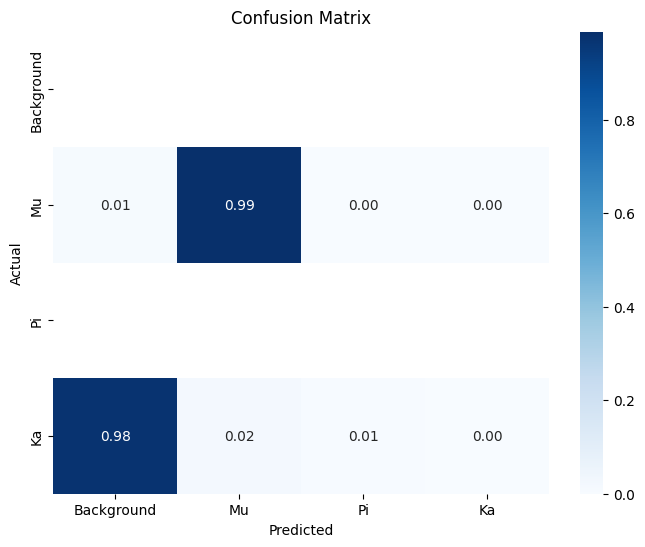

In [93]:
y_test_2 = label_encoder.transform(bdf[bdf.theta_p < 0.79].mass)
# y_pred_2 = model.predict(bdf[['momentum', 'unfixed_calculated_r_2d_4_rsigms_4_tsigms', 'theta_p', 'distance']])
y_pred_2 = label_encoder.transform(bdf[bdf.theta_p < 0.79].mass_reco)
cm = confusion_matrix(y_test_2, y_pred_2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Background', 'Mu', 'Pi', 'Ka']
# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()